In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

sns.set()

In [14]:
df =  pd.read_excel('../1_Data/datasets/2022_smd_hourly.xlsx' ,sheet_name='ISO NE CA')
df['Date'] = df.Date + pd.to_timedelta(df.Hr_End, unit='h')
df.sort_values('Date', inplace=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

features_considered =  ['DA_Demand', 'DA_EC', 'DA_CC', 'DA_MLC', 'Dry_Bulb', 'Dew_Point', 'RT_Demand']
features = df[features_considered]
features.index = df.index 

In [16]:
# normalize features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

# separate scaler for the target variable to avoid shape issues 
target = df['System_Load'].values.reshape(-1, 1)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# create data sequences
look_back = 24  
batch_size = 32  

# create the generator for the LSTM input
generator = TimeseriesGenerator(scaled_features, scaled_target,
                                length=look_back, batch_size=batch_size)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(look_back, len(features_considered))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=20)

last_24_hours_features = scaled_features[-look_back:]  
last_24_hours_features = last_24_hours_features.reshape((1, look_back, len(features_considered)))

predicted_demand_scaled = model.predict(last_24_hours_features)

predicted_demand = scaler_target.inverse_transform(predicted_demand_scaled)

Epoch 1/20


/tmp/ipykernel_6821/4035009412.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=20)


273/273 [==============================] - 3s 8ms/step - loss: 0.0102
Epoch 2/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0029
Epoch 3/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0017
Epoch 4/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 5/20
273/273 [==============================] - 2s 8ms/step - loss: 0.0012
Epoch 6/20
273/273 [==============================] - 2s 8ms/step - loss: 9.3324e-04
Epoch 7/20
273/273 [==============================] - 2s 8ms/step - loss: 9.1063e-04
Epoch 8/20
273/273 [==============================] - 2s 8ms/step - loss: 8.0018e-04
Epoch 9/20
273/273 [==============================] - 2s 8ms/step - loss: 7.8551e-04
Epoch 10/20
273/273 [==============================] - 2s 8ms/step - loss: 7.3619e-04
Epoch 11/20
273/273 [==============================] - 2s 8ms/step - loss: 6.9702e-04
Epoch 12/20
273/273 [==============================] - 2s 8ms/step - loss: 6.5023e-04
Epoch 13

# Predict the Next 24 Hours

In [17]:
input_features = last_24_hours_features.copy()

predicted_demand_scaled = []

for i in range(24):  
    current_pred = model.predict(input_features)
    predicted_demand_scaled.append(current_pred[0, 0]) 
    
    new_input = np.roll(input_features, -1, axis=1)  # Shift everything one step to the left
    new_input[0, -1, :] = current_pred  # set the last step to the new prediction
    
    input_features = new_input  

# Reshape the predictions to match the scaler's expected input
predicted_demand_scaled = np.array(predicted_demand_scaled).reshape(-1, 1)
predicted_demand = scaler_target.inverse_transform(predicted_demand_scaled)

1/1 [==============================] - 0s 13ms/step


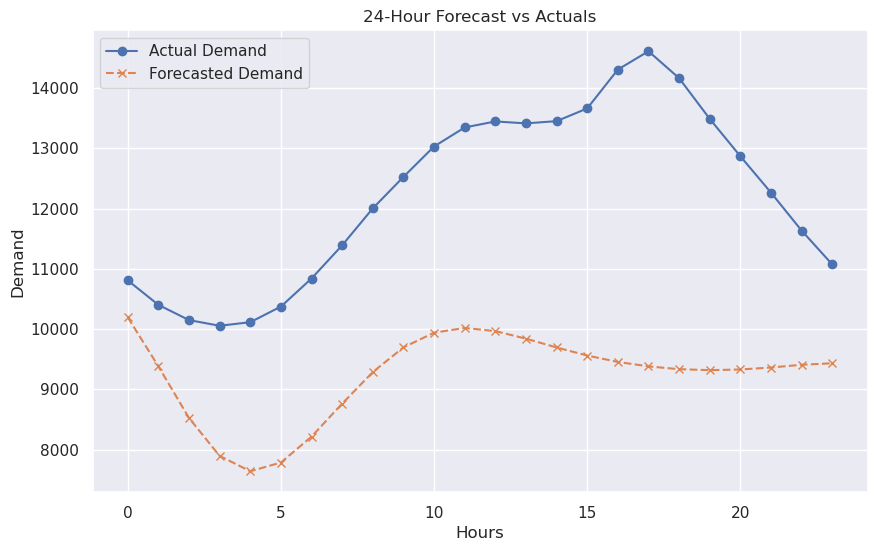

In [23]:
# Assuming you have actual demand data for the corresponding future 24 hours
actual_demand = df['System_Load'][-24:].values  

plt.figure(figsize=(10, 6))
plt.plot(range(24), actual_demand, label='Actual Demand', marker='o')
plt.plot(range(24), predicted_demand.flatten(), label='Forecasted Demand', marker='x', linestyle='--')
plt.title('24-Hour Forecast vs Actuals')
plt.xlabel('Hours')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_demand, predicted_demand)
mse = mean_squared_error(actual_demand, predicted_demand)
rmse = np.sqrt(mse)
r_squared = r2_score(actual_demand, predicted_demand)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r_squared}")

MAE: 2999.930623372396
MSE: 10307412.22022599
RMSE: 3210.515880699859
R-squared: -3.864885621092175


In [20]:
from sklearn.model_selection import train_test_split

# Assuming `scaled_features` and `scaled_target` are your features and target arrays
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42)

# Now create generators for both training and testing
train_generator = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)


In [21]:
model.fit_generator(train_generator, epochs=20)

Epoch 1/20
 13/219 [>.............................] - ETA: 1s - loss: 0.0574

/tmp/ipykernel_6821/993774087.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=20)


219/219 [==============================] - 2s 8ms/step - loss: 0.0311
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0288
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0287
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0285
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0286
Epoch 11/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0287
Epoch 12/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0285
Epoch 13/20
219/219 [===============

In [22]:
def calculate_importance(X, y, model, repeats=3):
    baseline_mse = mean_squared_error(y, model.predict(X))
    importances = []

    for i in range(X.shape[2]):  # Iterate over each feature
        mse_scores = []
        for _ in range(repeats):  # Repeat the permutation process
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, :, i])
            mse_permuted = mean_squared_error(y, model.predict(X_permuted))
            mse_scores.append(mse_permuted)
        
        # Calculate the importance as the increase in mse error
        importance = np.mean(mse_scores) - baseline_mse
        importances.append(importance)
    
    return importances

X_test_reshaped, y_test_reshaped = zip(*[test_generator[i] for i in range(len(test_generator))])
X_test_reshaped = np.vstack(X_test_reshaped)  
y_test_reshaped = np.vstack(y_test_reshaped)  

feature_importances = calculate_importance(X_test_reshaped, y_test_reshaped.flatten(), model, repeats=3)

print("Feature importances:", feature_importances)


54/54 [==============================] - 0s 3ms/step
Feature importances: [3.9378163986709264e-05, -1.7851647362308876e-05, -1.1584101128753188e-05, -3.1470893095297825e-05, -1.787425958163502e-05, 9.767107975180989e-05, 0.0002245185770766156]
